In [1]:
import numpy as np
import json
import warnings
import tensorflow as tf
from tensorflow.keras import models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, Input, Concatenate, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import json
from evaluator import *

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

In [ ]:
GRAYSCALE = False # grayscale or rgb # TODO: currently not working (MobileNetV2 does not support grayscale)
TRANSFORMER_IMPUTATION = True # whether to use transformer imputation or linear interpolation

# Import data

In [4]:
# file path to data folder
path = './Output' if not TRANSFORMER_IMPUTATION else './Output/transformer_imputation'

In [5]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')]), \
                             *np.load(path + '/feature_vector0.npy').shape
CHANNELS = len(VARIABLES) if GRAYSCALE else CHANNELS # reduce channels for grayscale

print(N, HEIGHT, WIDTH, CHANNELS)

613 370 497 30


Metadata (subjectID etc.)

In [6]:
with open(path + '/metadata.txt') as f:
    metadata = f.read()

metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

In [7]:
subjects = [meta['subjectID'] for meta in metadata]

# CNN

Addditional functions

In [8]:
# image-wise transformer
def rgb2gray(rgb):
    """greyscale = 0.2989 * red + 0.5870 * green + 0.1140 * blue"""
    return np.dot(rgb[:, :, :3], [0.2989, 0.5870, 0.1140])

# loss function
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits

# weight (imbalanced classes)
def check_imbalance(path_to_labels, indices, variable):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0]
    negatives = np.where(y[:, variable] == 0)[0]

    return np.array(indices)[positives], np.array(indices)[negatives]

def get_weighting_factor(path, train_set_indices, variable):
    positives, negatives = check_imbalance(path, train_set_indices, variable)
    sample_weight = len(negatives) / len(positives) # for weighted cross-entropy
    return sample_weight

Dataloader (dataset with images too large)

In [9]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, variable, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle
        assert variable in (0, 1)
        self.variable = variable

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # float: logits, int: non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            images = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            if GRAYSCALE:
                images_gray = np.empty((HEIGHT, WIDTH, self.n_channels))
                for j in range(len(VARIABLES)):
                    image_rgb = images[:, :, (3 * j): (3 * (j + 1))]
                    image_gray = rgb2gray(image_rgb)
                    images_gray[:, :, j] = image_gray
                images = images_gray

            X[i, ] = images
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[self.variable]

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

Architecture

In [10]:
class ConvNet(tf.keras.Model):

    def __init__(self, name='cnn', **kwargs):
        super(ConvNet, self).__init__(name, **kwargs)

        self.in_shape = (HEIGHT, WIDTH, CHANNELS)
        self.in_shape_mobilenet = (HEIGHT, WIDTH, 3) if not GRAYSCALE else (HEIGHT, WIDTH, 1)

        # MobileNetV2 embedding
        self.mobilenet = MobileNetV2(input_shape=self.in_shape_mobilenet, weights='imagenet', include_top=False)
        self.mobilenet._name = 'mobilenet'
        self.mobilenet.trainable = False
        self.finetuning = False
        self.out_shape_mobilenet = self.mobilenet.layers[-1].output_shape # for one spectrogram

        # Concatenation
        self.concat = Concatenate(name='concat')

        # Global pooling
        self.pool = GlobalAvgPool2D(name='global_avg_pool')

        # TODO: more sophisticated dense (dropout, regularizer, init., ...)
        # Fully-connected network
        self.dense = Dense(1, name='dense') # keep logits
        self.out_shape = 1

        # build graph
        self.build_graph()

    def build_graph(self):
        self.build(input_shape=(None, *self.in_shape))
        x = Input(shape=self.in_shape)
        Model(inputs=[x], outputs=self.call(x))

    def set_finetuning(self, mode=True):
        self.finetuning = mode
        self.mobilenet.trainable = mode

        for layers in self.mobilenet.layers:
            layers.trainable = False

        # "activate" last conv layer of MobileNet
        self.mobilenet.layers[-3].trainable = mode
        self.mobilenet.layers[-2].trainable = mode

    def call(self, inputs):
        """
        Model predictions (logits)
        :param inputs: all spectrograms of shape (HEIGHT, WIDTH, CHANNELS)
        :return: class prediction (logits)
        """
        # MobileNetV2 embeddings
        x = [self.mobilenet(inputs[..., i:i+3], training=self.finetuning) for i in range(0, CHANNELS, 3)]

        # Concatenation
        x = self.concat(x)

        # Global pooling
        x = self.pool(x)

        # Fully-connected network
        x = self.dense(x)

        return x

Model

In [15]:
class CNN:

    def __init__(self, path, variable, epochs, learning_rate, batch_size):
        self.model = ConvNet()
        self.path = path
        assert variable in (0, 1)
        self.variable = variable
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.history = None
        self.train_indices = None
        self.test_indices = None

    def fit(self, train_indices):
        self.train_indices = train_indices

        # training set
        train_dataloader = DataGenerator(self.path, train_indices, batch_size=self.batch_size, variable=self.variable)

        # weights for loss function
        sample_weights = get_weighting_factor(self.path, train_indices, self.variable)

        # build model
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                           loss=weighted_cross_entropy(sample_weights))

        # training
        self.history = self.model.fit_generator(generator=train_dataloader,
                                                epochs=self.epochs)

    def reset(self):
        """Resets model weights"""
        self.model = ConvNet()

    def predict(self, test_indices, logits=False):
        """Predicts actual class labels by default (not logits/probability values)"""
        self.test_indices = test_indices

        # TODO: make more efficient
        # test set + predict
        y_pred = np.empty(len(test_indices), dtype=float)

        for i, index in enumerate(test_indices):
            X_i = np.load(path + f'/feature_vector{index}.npy', allow_pickle=True)

            X_i = tf.expand_dims(X_i, axis=0) # add "batch dimension"
            logits_pred_i = self.model.predict(X_i)

            y_pred[i] = logits_pred_i

        if logits:
            return y_pred

        y_probs = tf.math.sigmoid(y_pred) # logits to probs
        y_pred = tf.round(y_probs) # probs to labels

        return y_pred

    def summary(self):
        return self.model.summary()

# CV

In [42]:
%%time
scores_strat_group_k_fold = [None]*2
scores_loso = [None]*2

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    for variable in (0, 1): # phF, MF
        model = CNN(path, variable=variable, epochs=5, learning_rate=1e-3, batch_size=16)

        scores_strat_group_k_fold[variable] = stratified_group_k_fold(path=path,
                                                            groups=subjects,
                                                            model=model,
                                                            folds=5,
                                                            images=True,
                                                            verbose=True,
                                                            variable=variable)

        scores_loso[variable] = leave_one_subject_out(path=path,
                                            groups=subjects,
                                            model=model,
                                            images=True,
                                            verbose=True,
                                            variable=variable)

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
31/31 [==============================] - 45s 648ms/step - loss: 0.5497
Epoch 2/5
31/31 [==============================] - 20s 648ms/step - loss: 0.3920
Epoch 3/5
31/31 [==============================] - 21s 651ms/step - loss: 0.3629
Epoch 4/5
31/31 [==============================] - 21s 650ms/step - loss: 0.3756
Epoch 5/5
31/31 [==============================] - 21s 649ms/step - loss: 0.3671


 Fold 1 F1: 0.8480687543218413:  20%|██        | 1/5 [02:41<10:47, 161.77s/it]

Epoch 1/5
20/20 [==============================] - 37s 643ms/step - loss: 0.6536
Epoch 2/5
20/20 [==============================] - 13s 641ms/step - loss: 0.4549
Epoch 3/5
20/20 [==============================] - 13s 644ms/step - loss: 0.3560
Epoch 4/5
20/20 [==============================] - 13s 643ms/step - loss: 0.3269
Epoch 5/5
20/20 [==============================] - 13s 651ms/step - loss: 0.3267


 Fold 2 F1: 0.6859633643921383:  40%|████      | 2/5 [05:13<07:46, 155.63s/it]

Epoch 1/5
31/31 [==============================] - 44s 643ms/step - loss: 0.5333
Epoch 2/5
31/31 [==============================] - 20s 644ms/step - loss: 0.3076
Epoch 3/5
31/31 [==============================] - 20s 639ms/step - loss: 0.2937
Epoch 4/5
31/31 [==============================] - 20s 637ms/step - loss: 0.2886
Epoch 5/5
31/31 [==============================] - 20s 636ms/step - loss: 0.2867


 Fold 3 F1: 0.5213955522238881:  60%|██████    | 3/5 [07:53<05:15, 157.68s/it]

Epoch 1/5
37/37 [==============================] - 48s 637ms/step - loss: 0.4824
Epoch 2/5
37/37 [==============================] - 24s 637ms/step - loss: 0.3341
Epoch 3/5
37/37 [==============================] - 24s 638ms/step - loss: 0.3369
Epoch 4/5
37/37 [==============================] - 24s 638ms/step - loss: 0.2844
Epoch 5/5
37/37 [==============================] - 24s 639ms/step - loss: 0.2675


 Fold 4 F1: 0.6961038961038962:  80%|████████  | 4/5 [10:32<02:38, 158.33s/it]

Epoch 1/5
32/32 [==============================] - 45s 646ms/step - loss: 0.4281
Epoch 2/5
32/32 [==============================] - 21s 647ms/step - loss: 0.2867
Epoch 3/5
32/32 [==============================] - 21s 647ms/step - loss: 0.2579
Epoch 4/5
32/32 [==============================] - 21s 646ms/step - loss: 0.2709
Epoch 5/5
32/32 [==============================] - 21s 646ms/step - loss: 0.2755


 Fold 5 F1: 0.4952926050350463: 100%|██████████| 5/5 [13:14<00:00, 158.82s/it]


Performance model:
 accuracy: 0.693 +- 0.087 

 balanced_accuracy: 0.53 +- 0.092 

 f1: 0.649 +- 0.129 

 recall: 0.693 +- 0.087 

 precision: 0.693 +- 0.148 

Starting leave-one-subject-out for physical fatigue


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/5
37/37 [==============================] - 49s 636ms/step - loss: 0.4084
Epoch 2/5
37/37 [==============================] - 24s 636ms/step - loss: 0.4000
Epoch 3/5
37/37 [==============================] - 24s 636ms/step - loss: 0.2878
Epoch 4/5
37/37 [==============================] - 24s 636ms/step - loss: 0.2912
Epoch 5/5
37/37 [==============================] - 24s 638ms/step - loss: 0.2474


 Fold 1 F1: 0.898989898989899:   4%|▎         | 1/27 [02:43<1:10:51, 163.50s/it]

Epoch 1/5
38/38 [==============================] - 48s 619ms/step - loss: 0.4977
Epoch 2/5
38/38 [==============================] - 24s 619ms/step - loss: 0.3654
Epoch 3/5
38/38 [==============================] - 24s 619ms/step - loss: 0.3045
Epoch 4/5
38/38 [==============================] - 24s 620ms/step - loss: 0.3192
Epoch 5/5
38/38 [==============================] - 24s 620ms/step - loss: 0.3182


 Fold 2 F1: 1.0:   7%|▋         | 2/27 [05:20<1:06:38, 159.94s/it]              

Epoch 1/5
37/37 [==============================] - 47s 635ms/step - loss: 0.4525
Epoch 2/5
37/37 [==============================] - 24s 636ms/step - loss: 0.3572
Epoch 3/5
37/37 [==============================] - 24s 637ms/step - loss: 0.3544
Epoch 4/5
37/37 [==============================] - 24s 636ms/step - loss: 0.2952
Epoch 5/5
37/37 [==============================] - 24s 636ms/step - loss: 0.2691


 Fold 3 F1: 0.5333333333333333:  11%|█         | 3/27 [08:00<1:03:58, 159.96s/it]

Epoch 1/5
37/37 [==============================] - 47s 628ms/step - loss: 0.4502
Epoch 2/5
37/37 [==============================] - 24s 628ms/step - loss: 0.4171
Epoch 3/5
37/37 [==============================] - 23s 623ms/step - loss: 0.3237
Epoch 4/5
37/37 [==============================] - 24s 627ms/step - loss: 0.3137
Epoch 5/5
37/37 [==============================] - 23s 625ms/step - loss: 0.2615


 Fold 4 F1: 0.494949494949495:  15%|█▍        | 4/27 [10:39<1:01:09, 159.55s/it] 

Epoch 1/5
37/37 [==============================] - 46s 626ms/step - loss: 0.5510
Epoch 2/5
37/37 [==============================] - 23s 624ms/step - loss: 0.3297
Epoch 3/5
37/37 [==============================] - 24s 625ms/step - loss: 0.3235
Epoch 4/5
37/37 [==============================] - 23s 625ms/step - loss: 0.2769
Epoch 5/5
37/37 [==============================] - 23s 625ms/step - loss: 0.2585


 Fold 5 F1: 1.0:  19%|█▊        | 5/27 [13:14<57:51, 157.81s/it]                

Epoch 1/5
37/37 [==============================] - 45s 619ms/step - loss: 0.4417
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.3706
Epoch 3/5
37/37 [==============================] - 23s 619ms/step - loss: 0.3736
Epoch 4/5
37/37 [==============================] - 23s 620ms/step - loss: 0.3107
Epoch 5/5
37/37 [==============================] - 23s 620ms/step - loss: 0.2776


 Fold 6 F1: 0.7111111111111111:  22%|██▏       | 6/27 [15:50<55:02, 157.24s/it]

Epoch 1/5
38/38 [==============================] - 48s 620ms/step - loss: 0.4631
Epoch 2/5
38/38 [==============================] - 24s 620ms/step - loss: 0.3535
Epoch 3/5
38/38 [==============================] - 24s 621ms/step - loss: 0.3035
Epoch 4/5
38/38 [==============================] - 24s 621ms/step - loss: 0.2758
Epoch 5/5
38/38 [==============================] - 24s 621ms/step - loss: 0.2653


 Fold 7 F1: 1.0:  26%|██▌       | 7/27 [18:31<52:45, 158.29s/it]               

Epoch 1/5
37/37 [==============================] - 46s 634ms/step - loss: 0.4066
Epoch 2/5
37/37 [==============================] - 24s 634ms/step - loss: 0.3699
Epoch 3/5
37/37 [==============================] - 24s 632ms/step - loss: 0.3369
Epoch 4/5
37/37 [==============================] - 24s 635ms/step - loss: 0.3171
Epoch 5/5
37/37 [==============================] - 24s 635ms/step - loss: 0.2610


 Fold 8 F1: 0.22892156862745097:  30%|██▉       | 8/27 [21:08<50:00, 157.91s/it]

Epoch 1/5
37/37 [==============================] - 49s 618ms/step - loss: 0.5314
Epoch 2/5
37/37 [==============================] - 23s 617ms/step - loss: 0.3446
Epoch 3/5
37/37 [==============================] - 23s 618ms/step - loss: 0.3364
Epoch 4/5
37/37 [==============================] - 23s 618ms/step - loss: 0.2901
Epoch 5/5
37/37 [==============================] - 23s 618ms/step - loss: 0.2544


 Fold 9 F1: 0.6703296703296704:  33%|███▎      | 9/27 [23:44<47:14, 157.47s/it] 

Epoch 1/5
37/37 [==============================] - 48s 627ms/step - loss: 0.5602
Epoch 2/5
37/37 [==============================] - 24s 625ms/step - loss: 0.3535
Epoch 3/5
37/37 [==============================] - 23s 625ms/step - loss: 0.3134
Epoch 4/5
37/37 [==============================] - 24s 626ms/step - loss: 0.3121
Epoch 5/5
37/37 [==============================] - 23s 625ms/step - loss: 0.2878


 Fold 10 F1: 0.5333333333333333:  37%|███▋      | 10/27 [26:21<44:30, 157.11s/it]

Epoch 1/5
37/37 [==============================] - 48s 618ms/step - loss: 0.5285
Epoch 2/5
37/37 [==============================] - 23s 617ms/step - loss: 0.3789
Epoch 3/5
37/37 [==============================] - 23s 619ms/step - loss: 0.3652
Epoch 4/5
37/37 [==============================] - 23s 619ms/step - loss: 0.3051
Epoch 5/5
37/37 [==============================] - 23s 618ms/step - loss: 0.2713


 Fold 11 F1: 0.3076923076923077:  41%|████      | 11/27 [28:57<41:50, 156.93s/it]

Epoch 1/5
37/37 [==============================] - 47s 625ms/step - loss: 0.5061
Epoch 2/5
37/37 [==============================] - 23s 625ms/step - loss: 0.3576
Epoch 3/5
37/37 [==============================] - 23s 624ms/step - loss: 0.3161
Epoch 4/5
37/37 [==============================] - 24s 626ms/step - loss: 0.3513
Epoch 5/5
37/37 [==============================] - 24s 626ms/step - loss: 0.3022


 Fold 12 F1: 0.047619047619047616:  44%|████▍     | 12/27 [31:33<39:11, 156.74s/it]

Epoch 1/5
37/37 [==============================] - 49s 622ms/step - loss: 0.4862
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.3279
Epoch 3/5
37/37 [==============================] - 23s 623ms/step - loss: 0.3287
Epoch 4/5
37/37 [==============================] - 23s 622ms/step - loss: 0.2945
Epoch 5/5
37/37 [==============================] - 23s 622ms/step - loss: 0.3107


 Fold 13 F1: 0.49122807017543857:  48%|████▊     | 13/27 [34:11<36:37, 156.99s/it] 

Epoch 1/5
37/37 [==============================] - 47s 620ms/step - loss: 0.5164
Epoch 2/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4345
Epoch 3/5
37/37 [==============================] - 23s 619ms/step - loss: 0.3938
Epoch 4/5
37/37 [==============================] - 23s 621ms/step - loss: 0.2792
Epoch 5/5
37/37 [==============================] - 23s 622ms/step - loss: 0.2868


 Fold 14 F1: 1.0:  52%|█████▏    | 14/27 [36:46<33:51, 156.30s/it]                

Epoch 1/5
37/37 [==============================] - 49s 628ms/step - loss: 0.4541
Epoch 2/5
37/37 [==============================] - 24s 629ms/step - loss: 0.3739
Epoch 3/5
37/37 [==============================] - 24s 629ms/step - loss: 0.3332
Epoch 4/5
37/37 [==============================] - 24s 628ms/step - loss: 0.2874
Epoch 5/5
37/37 [==============================] - 24s 628ms/step - loss: 0.2870


 Fold 15 F1: 0.3981900452488688:  56%|█████▌    | 15/27 [39:25<31:25, 157.12s/it]

Epoch 1/5
37/37 [==============================] - 47s 619ms/step - loss: 0.4158
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.3297
Epoch 3/5
37/37 [==============================] - 23s 620ms/step - loss: 0.3601
Epoch 4/5
37/37 [==============================] - 23s 620ms/step - loss: 0.2720
Epoch 5/5
37/37 [==============================] - 23s 621ms/step - loss: 0.2614


 Fold 16 F1: 0.6363636363636364:  59%|█████▉    | 16/27 [42:00<28:42, 156.56s/it]

Epoch 1/5
37/37 [==============================] - 46s 623ms/step - loss: 0.4121
Epoch 2/5
37/37 [==============================] - 23s 623ms/step - loss: 0.3282
Epoch 3/5
37/37 [==============================] - 23s 624ms/step - loss: 0.3344
Epoch 4/5
37/37 [==============================] - 23s 623ms/step - loss: 0.2682
Epoch 5/5
37/37 [==============================] - 23s 622ms/step - loss: 0.2498


 Fold 17 F1: 0.8181818181818182:  63%|██████▎   | 17/27 [44:38<26:09, 156.95s/it]

Epoch 1/5
37/37 [==============================] - 47s 619ms/step - loss: 0.3800
Epoch 2/5
37/37 [==============================] - 23s 618ms/step - loss: 0.3639
Epoch 3/5
37/37 [==============================] - 23s 621ms/step - loss: 0.3552
Epoch 4/5
37/37 [==============================] - 23s 620ms/step - loss: 0.2609
Epoch 5/5
37/37 [==============================] - 23s 621ms/step - loss: 0.2580


 Fold 18 F1: 0.9137254901960784:  67%|██████▋   | 18/27 [47:16<23:36, 157.38s/it]

Epoch 1/5
37/37 [==============================] - 46s 625ms/step - loss: 0.3950
Epoch 2/5
37/37 [==============================] - 24s 628ms/step - loss: 0.4657
Epoch 3/5
37/37 [==============================] - 24s 627ms/step - loss: 0.3272
Epoch 4/5
37/37 [==============================] - 24s 626ms/step - loss: 0.2835
Epoch 5/5
37/37 [==============================] - 24s 627ms/step - loss: 0.2720


 Fold 19 F1: 1.0:  70%|███████   | 19/27 [49:52<20:54, 156.84s/it]               

Epoch 1/5
37/37 [==============================] - 49s 620ms/step - loss: 0.5850
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4277
Epoch 3/5
37/37 [==============================] - 23s 621ms/step - loss: 0.3258
Epoch 4/5
37/37 [==============================] - 23s 622ms/step - loss: 0.3247
Epoch 5/5
37/37 [==============================] - 23s 622ms/step - loss: 0.2783


 Fold 20 F1: 1.0:  74%|███████▍  | 20/27 [52:28<18:16, 156.70s/it]

Epoch 1/5
37/37 [==============================] - 47s 619ms/step - loss: 0.4349
Epoch 2/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4534
Epoch 3/5
37/37 [==============================] - 23s 619ms/step - loss: 0.3268
Epoch 4/5
37/37 [==============================] - 23s 620ms/step - loss: 0.2868
Epoch 5/5
37/37 [==============================] - 23s 620ms/step - loss: 0.2646


 Fold 21 F1: 0.8181818181818182:  78%|███████▊  | 21/27 [55:03<15:36, 156.16s/it]

Epoch 1/5
37/37 [==============================] - 46s 623ms/step - loss: 0.4492
Epoch 2/5
37/37 [==============================] - 24s 625ms/step - loss: 0.3645
Epoch 3/5
37/37 [==============================] - 23s 625ms/step - loss: 0.3364
Epoch 4/5
37/37 [==============================] - 23s 625ms/step - loss: 0.3070
Epoch 5/5
37/37 [==============================] - 24s 626ms/step - loss: 0.2740


 Fold 22 F1: 0.6666666666666669:  81%|████████▏ | 22/27 [57:41<13:03, 156.75s/it]

Epoch 1/5
32/32 [==============================] - 44s 619ms/step - loss: 0.3887
Epoch 2/5
32/32 [==============================] - 20s 620ms/step - loss: 0.2995
Epoch 3/5
32/32 [==============================] - 20s 621ms/step - loss: 0.2520
Epoch 4/5
32/32 [==============================] - 20s 620ms/step - loss: 0.2521
Epoch 5/5
32/32 [==============================] - 20s 619ms/step - loss: 0.2123


 Fold 23 F1: 0.5620689655172414:  85%|████████▌ | 23/27 [1:00:16<10:24, 156.23s/it]

Epoch 1/5
29/29 [==============================] - 41s 627ms/step - loss: 0.5990
Epoch 2/5
29/29 [==============================] - 19s 629ms/step - loss: 0.4778
Epoch 3/5
29/29 [==============================] - 19s 627ms/step - loss: 0.4436
Epoch 4/5
29/29 [==============================] - 19s 628ms/step - loss: 0.3655
Epoch 5/5
29/29 [==============================] - 19s 628ms/step - loss: 0.4060


 Fold 24 F1: 0.9379432624113474:  89%|████████▉ | 24/27 [1:02:46<07:42, 154.21s/it]

Epoch 1/5
36/36 [==============================] - 49s 621ms/step - loss: 0.4158
Epoch 2/5
36/36 [==============================] - 23s 620ms/step - loss: 0.3158
Epoch 3/5
36/36 [==============================] - 23s 620ms/step - loss: 0.3207
Epoch 4/5
36/36 [==============================] - 23s 621ms/step - loss: 0.2638
Epoch 5/5
36/36 [==============================] - 23s 621ms/step - loss: 0.2333


 Fold 25 F1: 0.3793103448275862:  93%|█████████▎| 25/27 [1:05:23<05:10, 155.02s/it]

Epoch 1/5
33/33 [==============================] - 45s 623ms/step - loss: 0.4845
Epoch 2/5
33/33 [==============================] - 21s 624ms/step - loss: 0.4290
Epoch 3/5
33/33 [==============================] - 21s 625ms/step - loss: 0.4027
Epoch 4/5
33/33 [==============================] - 21s 624ms/step - loss: 0.3388
Epoch 5/5
33/33 [==============================] - 21s 625ms/step - loss: 0.3149


 Fold 26 F1: 0.9792152292152293:  96%|█████████▋| 26/27 [1:07:58<02:35, 155.08s/it]

Epoch 1/5
35/35 [==============================] - 46s 637ms/step - loss: 0.4412
Epoch 2/5
35/35 [==============================] - 23s 636ms/step - loss: 0.3221
Epoch 3/5
35/35 [==============================] - 23s 638ms/step - loss: 0.3068
Epoch 4/5
35/35 [==============================] - 23s 636ms/step - loss: 0.2402
Epoch 5/5
35/35 [==============================] - 23s 638ms/step - loss: 0.2327


 Fold 27 F1: 0.3542640444483641: 100%|██████████| 27/27 [1:10:34<00:00, 156.83s/it]

Performance model:
 accuracy: 0.7 +- 0.268 

 balanced_accuracy: 0.645 +- 0.254 

 f1: 0.681 +- 0.276 

 recall: 0.7 +- 0.268 

 precision: 0.732 +- 0.26 



Starting stratified group 5-fold for mental fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
36/36 [==============================] - 49s 627ms/step - loss: 0.6620
Epoch 2/5
36/36 [==============================] - 23s 628ms/step - loss: 0.4975
Epoch 3/5
36/36 [==============================] - 23s 627ms/step - loss: 0.5049
Epoch 4/5
36/36 [==============================] - 23s 628ms/step - loss: 0.4296
Epoch 5/5
36/36 [==============================] - 23s 628ms/step - loss: 0.4010


 Fold 1 F1: 0.3125:  20%|██        | 1/5 [02:39<10:39, 159.89s/it]

Epoch 1/5
22/22 [==============================] - 37s 616ms/step - loss: 0.5923
Epoch 2/5
22/22 [==============================] - 14s 616ms/step - loss: 0.5801
Epoch 3/5
22/22 [==============================] - 14s 619ms/step - loss: 0.4347
Epoch 4/5
22/22 [==============================] - 14s 619ms/step - loss: 0.3665
Epoch 5/5
22/22 [==============================] - 14s 618ms/step - loss: 0.3454


 Fold 2 F1: 0.515654786572731:  40%|████      | 2/5 [05:07<07:37, 152.55s/it]

Epoch 1/5
37/37 [==============================] - 46s 620ms/step - loss: 0.6301
Epoch 2/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4062
Epoch 3/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4290
Epoch 4/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4221
Epoch 5/5
37/37 [==============================] - 23s 620ms/step - loss: 0.3447


 Fold 3 F1: 0.625:  60%|██████    | 3/5 [07:41<05:06, 153.38s/it]            

Epoch 1/5
32/32 [==============================] - 46s 625ms/step - loss: 0.5379
Epoch 2/5
32/32 [==============================] - 20s 624ms/step - loss: 0.3975
Epoch 3/5
32/32 [==============================] - 20s 624ms/step - loss: 0.4559
Epoch 4/5
32/32 [==============================] - 20s 623ms/step - loss: 0.3872
Epoch 5/5
32/32 [==============================] - 20s 624ms/step - loss: 0.4057


 Fold 4 F1: 0.4678544200172477:  80%|████████  | 4/5 [10:15<02:33, 153.74s/it]

Epoch 1/5
24/24 [==============================] - 40s 628ms/step - loss: 0.6907
Epoch 2/5
24/24 [==============================] - 15s 628ms/step - loss: 0.4938
Epoch 3/5
24/24 [==============================] - 15s 630ms/step - loss: 0.4684
Epoch 4/5
24/24 [==============================] - 15s 629ms/step - loss: 0.4257
Epoch 5/5
24/24 [==============================] - 15s 630ms/step - loss: 0.4009


 Fold 5 F1: 0.5861603303137647: 100%|██████████| 5/5 [12:45<00:00, 153.01s/it]


Performance model:
 accuracy: 0.471 +- 0.086 

 balanced_accuracy: 0.526 +- 0.047 

 f1: 0.501 +- 0.109 

 recall: 0.471 +- 0.086 

 precision: 0.742 +- 0.165 

Starting leave-one-subject-out for mental fatigue


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/5
37/37 [==============================] - 47s 633ms/step - loss: 0.5351
Epoch 2/5
37/37 [==============================] - 24s 633ms/step - loss: 0.4610
Epoch 3/5
37/37 [==============================] - 24s 634ms/step - loss: 0.4071
Epoch 4/5
37/37 [==============================] - 24s 633ms/step - loss: 0.4333
Epoch 5/5
37/37 [==============================] - 24s 634ms/step - loss: 0.4273


 Fold 1 F1: 0.2787878787878788:   4%|▎         | 1/27 [02:39<1:09:15, 159.82s/it]

Epoch 1/5
38/38 [==============================] - 48s 628ms/step - loss: 0.5645
Epoch 2/5
38/38 [==============================] - 24s 630ms/step - loss: 0.4671
Epoch 3/5
38/38 [==============================] - 24s 628ms/step - loss: 0.4316
Epoch 4/5
38/38 [==============================] - 24s 629ms/step - loss: 0.4323
Epoch 5/5
38/38 [==============================] - 24s 628ms/step - loss: 0.3801


 Fold 2 F1: 1.0:   7%|▋         | 2/27 [05:21<1:07:03, 160.93s/it]               

Epoch 1/5
37/37 [==============================] - 47s 633ms/step - loss: 0.5618
Epoch 2/5
37/37 [==============================] - 24s 634ms/step - loss: 0.4299
Epoch 3/5
37/37 [==============================] - 24s 631ms/step - loss: 0.4427
Epoch 4/5
37/37 [==============================] - 24s 632ms/step - loss: 0.4252
Epoch 5/5
37/37 [==============================] - 24s 632ms/step - loss: 0.4437


 Fold 3 F1: 0.2450980392156863:  11%|█         | 3/27 [07:58<1:03:37, 159.05s/it]

Epoch 1/5
37/37 [==============================] - 49s 622ms/step - loss: 0.5647
Epoch 2/5
37/37 [==============================] - 23s 623ms/step - loss: 0.4298
Epoch 3/5
37/37 [==============================] - 23s 623ms/step - loss: 0.4203
Epoch 4/5
37/37 [==============================] - 23s 623ms/step - loss: 0.5260
Epoch 5/5
37/37 [==============================] - 24s 638ms/step - loss: 0.4356


 Fold 4 F1: 0.4588744588744589:  15%|█▍        | 4/27 [10:36<1:00:50, 158.70s/it]

Epoch 1/5
37/37 [==============================] - 49s 617ms/step - loss: 0.5238
Epoch 2/5
37/37 [==============================] - 23s 619ms/step - loss: 0.4789
Epoch 3/5
37/37 [==============================] - 23s 620ms/step - loss: 0.5275
Epoch 4/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4309
Epoch 5/5
37/37 [==============================] - 23s 620ms/step - loss: 0.3738


 Fold 5 F1: 0.0:  19%|█▊        | 5/27 [13:15<58:12, 158.75s/it]                 

Epoch 1/5
37/37 [==============================] - 49s 620ms/step - loss: 0.5399
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4953
Epoch 3/5
37/37 [==============================] - 23s 619ms/step - loss: 0.4574
Epoch 4/5
37/37 [==============================] - 23s 618ms/step - loss: 0.4429
Epoch 5/5
37/37 [==============================] - 23s 618ms/step - loss: 0.3748


 Fold 6 F1: 0.6333333333333333:  22%|██▏       | 6/27 [15:52<55:21, 158.16s/it]

Epoch 1/5
38/38 [==============================] - 48s 620ms/step - loss: 0.5602
Epoch 2/5
38/38 [==============================] - 24s 620ms/step - loss: 0.5021
Epoch 3/5
38/38 [==============================] - 24s 621ms/step - loss: 0.5097
Epoch 4/5
38/38 [==============================] - 24s 621ms/step - loss: 0.5102
Epoch 5/5
38/38 [==============================] - 24s 621ms/step - loss: 0.3810


 Fold 7 F1: 0.6666666666666666:  26%|██▌       | 7/27 [18:30<52:40, 158.04s/it]

Epoch 1/5
37/37 [==============================] - 49s 626ms/step - loss: 0.5758
Epoch 2/5
37/37 [==============================] - 24s 626ms/step - loss: 0.4393
Epoch 3/5
37/37 [==============================] - 24s 626ms/step - loss: 0.4642
Epoch 4/5
37/37 [==============================] - 24s 626ms/step - loss: 0.4593
Epoch 5/5
37/37 [==============================] - 24s 626ms/step - loss: 0.4076


 Fold 8 F1: 0.44967532467532456:  30%|██▉       | 8/27 [21:09<50:10, 158.42s/it]

Epoch 1/5
37/37 [==============================] - 47s 619ms/step - loss: 0.6333
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4541
Epoch 3/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4344
Epoch 4/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4237
Epoch 5/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4383


 Fold 9 F1: 0.18181818181818182:  33%|███▎      | 9/27 [23:44<47:13, 157.43s/it]

Epoch 1/5
37/37 [==============================] - 49s 622ms/step - loss: 0.5285
Epoch 2/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4582
Epoch 3/5
37/37 [==============================] - 23s 624ms/step - loss: 0.4000
Epoch 4/5
37/37 [==============================] - 23s 624ms/step - loss: 0.3618
Epoch 5/5
37/37 [==============================] - 23s 623ms/step - loss: 0.3561


 Fold 10 F1: 0.494949494949495:  37%|███▋      | 10/27 [26:21<44:34, 157.34s/it] 

Epoch 1/5
37/37 [==============================] - 47s 625ms/step - loss: 0.5631
Epoch 2/5
37/37 [==============================] - 24s 626ms/step - loss: 0.4490
Epoch 3/5
37/37 [==============================] - 24s 629ms/step - loss: 0.4037
Epoch 4/5
37/37 [==============================] - 24s 625ms/step - loss: 0.4180
Epoch 5/5
37/37 [==============================] - 24s 628ms/step - loss: 0.4113


 Fold 11 F1: 0.3981900452488688:  41%|████      | 11/27 [28:58<41:55, 157.24s/it]

Epoch 1/5
37/37 [==============================] - 50s 629ms/step - loss: 0.5445
Epoch 2/5
37/37 [==============================] - 24s 627ms/step - loss: 0.4486
Epoch 3/5
37/37 [==============================] - 24s 628ms/step - loss: 0.4164
Epoch 4/5
37/37 [==============================] - 24s 628ms/step - loss: 0.4572
Epoch 5/5
37/37 [==============================] - 24s 627ms/step - loss: 0.4675


 Fold 12 F1: 0.7368421052631579:  44%|████▍     | 12/27 [31:37<39:27, 157.84s/it]

Epoch 1/5
37/37 [==============================] - 47s 619ms/step - loss: 0.6147
Epoch 2/5
37/37 [==============================] - 23s 618ms/step - loss: 0.4867
Epoch 3/5
37/37 [==============================] - 23s 619ms/step - loss: 0.4180
Epoch 4/5
37/37 [==============================] - 23s 620ms/step - loss: 0.4183
Epoch 5/5
37/37 [==============================] - 23s 619ms/step - loss: 0.3772


 Fold 13 F1: 0.3523809523809524:  48%|████▊     | 13/27 [34:13<36:39, 157.12s/it]

Epoch 1/5
37/37 [==============================] - 47s 635ms/step - loss: 0.5326
Epoch 2/5
37/37 [==============================] - 24s 636ms/step - loss: 0.4373
Epoch 3/5
37/37 [==============================] - 24s 637ms/step - loss: 0.4643
Epoch 4/5
37/37 [==============================] - 24s 636ms/step - loss: 0.3994
Epoch 5/5
37/37 [==============================] - 24s 636ms/step - loss: 0.3779


 Fold 14 F1: 0.19444444444444445:  52%|█████▏    | 14/27 [36:53<34:13, 157.99s/it]

Epoch 1/5
37/37 [==============================] - 47s 619ms/step - loss: 0.6620
Epoch 2/5
37/37 [==============================] - 23s 623ms/step - loss: 0.5465
Epoch 3/5
37/37 [==============================] - 23s 621ms/step - loss: 0.4529
Epoch 4/5
37/37 [==============================] - 23s 622ms/step - loss: 0.4453
Epoch 5/5
37/37 [==============================] - 23s 622ms/step - loss: 0.3784


 Fold 15 F1: 0.48653846153846153:  56%|█████▌    | 15/27 [39:32<31:41, 158.44s/it]

Epoch 1/5
37/37 [==============================] - 47s 622ms/step - loss: 0.5800
Epoch 2/5
37/37 [==============================] - 23s 622ms/step - loss: 0.4909
Epoch 3/5
37/37 [==============================] - 23s 624ms/step - loss: 0.4315
Epoch 4/5
37/37 [==============================] - 23s 625ms/step - loss: 0.3978
Epoch 5/5
37/37 [==============================] - 23s 622ms/step - loss: 0.3692


 Fold 16 F1: 0.6889952153110048:  59%|█████▉    | 16/27 [42:08<28:54, 157.69s/it] 

Epoch 1/5
37/37 [==============================] - 50s 636ms/step - loss: 0.6106
Epoch 2/5
37/37 [==============================] - 24s 636ms/step - loss: 0.4663
Epoch 3/5
37/37 [==============================] - 24s 635ms/step - loss: 0.4311
Epoch 4/5
37/37 [==============================] - 24s 635ms/step - loss: 0.4682
Epoch 5/5
37/37 [==============================] - 24s 636ms/step - loss: 0.3703


 Fold 17 F1: 0.4454545454545455:  63%|██████▎   | 17/27 [44:49<26:26, 158.64s/it]

Epoch 1/5
37/37 [==============================] - 48s 631ms/step - loss: 0.6495
Epoch 2/5
37/37 [==============================] - 24s 630ms/step - loss: 0.4423
Epoch 3/5
37/37 [==============================] - 24s 632ms/step - loss: 0.4275
Epoch 4/5
37/37 [==============================] - 24s 631ms/step - loss: 0.4151
Epoch 5/5
37/37 [==============================] - 24s 631ms/step - loss: 0.4073


 Fold 18 F1: 0.2285714285714286:  67%|██████▋   | 18/27 [47:27<23:46, 158.49s/it]

Epoch 1/5
37/37 [==============================] - 50s 638ms/step - loss: 0.5159
Epoch 2/5
37/37 [==============================] - 24s 637ms/step - loss: 0.4476
Epoch 3/5
37/37 [==============================] - 24s 638ms/step - loss: 0.4088
Epoch 4/5
37/37 [==============================] - 24s 637ms/step - loss: 0.3842
Epoch 5/5
37/37 [==============================] - 24s 638ms/step - loss: 0.4208


 Fold 19 F1: 0.5764705882352941:  70%|███████   | 19/27 [50:09<21:14, 159.28s/it]

Epoch 1/5
37/37 [==============================] - 48s 623ms/step - loss: 0.5818
Epoch 2/5
37/37 [==============================] - 23s 623ms/step - loss: 0.5001
Epoch 3/5
37/37 [==============================] - 23s 622ms/step - loss: 0.4320
Epoch 4/5
37/37 [==============================] - 23s 624ms/step - loss: 0.3980
Epoch 5/5
37/37 [==============================] - 23s 623ms/step - loss: 0.4262


 Fold 20 F1: 0.0:  74%|███████▍  | 20/27 [52:45<18:28, 158.31s/it]               

Epoch 1/5
37/37 [==============================] - 50s 628ms/step - loss: 0.4984
Epoch 2/5
37/37 [==============================] - 24s 627ms/step - loss: 0.5246
Epoch 3/5
37/37 [==============================] - 24s 627ms/step - loss: 0.4228
Epoch 4/5
37/37 [==============================] - 24s 627ms/step - loss: 0.3717
Epoch 5/5
37/37 [==============================] - 24s 628ms/step - loss: 0.3381


 Fold 21 F1: 0.7777777777777778:  78%|███████▊  | 21/27 [55:24<15:52, 158.71s/it]

Epoch 1/5
37/37 [==============================] - 49s 636ms/step - loss: 0.5593
Epoch 2/5
37/37 [==============================] - 24s 637ms/step - loss: 0.4800
Epoch 3/5
37/37 [==============================] - 24s 637ms/step - loss: 0.5039
Epoch 4/5
37/37 [==============================] - 24s 637ms/step - loss: 0.4484
Epoch 5/5
37/37 [==============================] - 24s 637ms/step - loss: 0.3966


 Fold 22 F1: 0.16666666666666666:  81%|████████▏ | 22/27 [58:04<13:15, 159.04s/it]

Epoch 1/5
32/32 [==============================] - 47s 629ms/step - loss: 0.6191
Epoch 2/5
32/32 [==============================] - 20s 629ms/step - loss: 0.4479
Epoch 3/5
32/32 [==============================] - 20s 629ms/step - loss: 0.4258
Epoch 4/5
32/32 [==============================] - 21s 629ms/step - loss: 0.3787
Epoch 5/5
32/32 [==============================] - 21s 629ms/step - loss: 0.3666


 Fold 23 F1: 0.6091428571428571:  85%|████████▌ | 23/27 [1:00:41<10:33, 158.47s/it] 

Epoch 1/5
29/29 [==============================] - 43s 623ms/step - loss: 0.6860
Epoch 2/5
29/29 [==============================] - 18s 624ms/step - loss: 0.5459
Epoch 3/5
29/29 [==============================] - 18s 624ms/step - loss: 0.4838
Epoch 4/5
29/29 [==============================] - 18s 624ms/step - loss: 0.4505
Epoch 5/5
29/29 [==============================] - 18s 625ms/step - loss: 0.4292


 Fold 24 F1: 0.5753250591016549:  89%|████████▉ | 24/27 [1:03:14<07:50, 156.72s/it]

Epoch 1/5
36/36 [==============================] - 50s 626ms/step - loss: 0.5297
Epoch 2/5
36/36 [==============================] - 23s 625ms/step - loss: 0.4955
Epoch 3/5
36/36 [==============================] - 23s 625ms/step - loss: 0.4363
Epoch 4/5
36/36 [==============================] - 23s 625ms/step - loss: 0.3939
Epoch 5/5
36/36 [==============================] - 23s 628ms/step - loss: 0.4459


 Fold 25 F1: 0.4730792498487598:  93%|█████████▎| 25/27 [1:05:53<05:14, 157.43s/it]

Epoch 1/5
33/33 [==============================] - 45s 621ms/step - loss: 0.7661
Epoch 2/5
33/33 [==============================] - 21s 621ms/step - loss: 0.5284
Epoch 3/5
33/33 [==============================] - 21s 622ms/step - loss: 0.4815
Epoch 4/5
33/33 [==============================] - 21s 623ms/step - loss: 0.4969
Epoch 5/5
33/33 [==============================] - 21s 622ms/step - loss: 0.4145


 Fold 26 F1: 0.5111919319699205:  96%|█████████▋| 26/27 [1:08:26<02:36, 156.08s/it]

Epoch 1/5
35/35 [==============================] - 46s 630ms/step - loss: 0.6154
Epoch 2/5
35/35 [==============================] - 22s 630ms/step - loss: 0.4004
Epoch 3/5
35/35 [==============================] - 22s 631ms/step - loss: 0.3903
Epoch 4/5
35/35 [==============================] - 22s 631ms/step - loss: 0.3547
Epoch 5/5
35/35 [==============================] - 23s 632ms/step - loss: 0.4165


 Fold 27 F1: 0.5148741418764302: 100%|██████████| 27/27 [1:11:05<00:00, 157.97s/it]

Performance model:
 accuracy: 0.456 +- 0.223 

 balanced_accuracy: 0.455 +- 0.225 

 f1: 0.45 +- 0.232 

 recall: 0.456 +- 0.223 

 precision: 0.58 +- 0.314 



# Save scores

In [29]:
path_scores = './Scores'
model_name = 'cnn (transformer imputation)'

In [30]:
# stratified group 5-fold
with open(f'{path_scores}/strat_group_5_fold//{model_name}.txt', 'w') as dat:
    dat.write(str(scores_strat_group_k_fold))

In [31]:
# LOSO
with open(f'{path_scores}/loso//{model_name}.txt', 'w') as dat:
    dat.write(str(scores_loso))

# Under development

Training curve (for analyzation of n_epochs, learning-rate, ...)

In [40]:
variable = 0
folds = 5
groups = subjects
epochs = 10

# use validation data every epoch
history_val = {'accuracy': [],
               'balanced_accuracy': [],
               'f1': [],
               'recall': [],
               'precision': [],
               'val_loss': []}

model = CNN(path, variable=variable, epochs=epochs, learning_rate=1e-3, batch_size=2)

# calculate data size
N = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')])

# load labels (we need them for stratification)
y = np.empty(N, dtype=int)
for i in range(N):
    y[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[variable]  # TODO: multiclass

# CV
cv = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=SEED)
scores_cv = []
data_indices = np.arange(N)

print(f'Starting stratified group {folds}-fold for {["physical fatigue", "mental fatigue"][variable]}')
with tqdm(total=folds) as pbar:
    for i, (train_indices, test_indices) in enumerate(cv.split(X=data_indices, y=y, groups=groups)):
        # test labels
        y_test = y[test_indices]

        # training
        try:
            model.reset()
        except AttributeError:
            pass  # model has no trainable parameters
        # compile
        sample_weights = get_weighting_factor(model.path, train_indices, variable)
        model.model.compile(optimizer=Adam(learning_rate=model.learning_rate),
                      loss=weighted_cross_entropy(sample_weights))
        train_dataloader = DataGenerator(model.path, train_indices, batch_size=model.batch_size, variable=variable)
        # training epochs
        for i in range(epochs):
            model.model.fit_generator(generator=train_dataloader,
                                      epochs=1)

            # validation
            y_logits = model.predict(test_indices, logits=True)
            y_probs = tf.math.sigmoid(y_logits) # logits to probs
            y_pred = tf.round(y_probs) # probs to labels

            # evaluate
            scores = evaluator(y_pred, y_test, verbose=False)
            metrics = history_val.keys()
            for metric in metrics:
                if metric == 'val_loss':
                    history_val['val_loss'].append(np.mean(weighted_cross_entropy(sample_weights)(labels=tf.convert_to_tensor(y_test, dtype=float), logits=tf.convert_to_tensor(y_logits, dtype=float))))
                else:
                    history_val[metric].append(scores[metric])

            del y_logits
            del y_probs
            del y_pred

        break # only do one iteration

        # for progress bar
        pbar.update(1)
        pbar.set_description(f' Fold {i + 1} F1: {scores["f1"]}')

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 57s 132ms/step - loss: 0.6910


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 132ms/step - loss: 0.5121


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 33s 132ms/step - loss: 0.4000


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 133ms/step - loss: 0.3760


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 133ms/step - loss: 0.4093


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 132ms/step - loss: 0.2770


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 33s 131ms/step - loss: 0.3015


  0%|          | 0/5 [06:57<?, ?it/s]


ResourceExhaustedError:  OOM when allocating tensor with shape[96,187,251] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv_net_17/mobilenet/block_1_pad/Pad_8 (defined at \AppData\Local\Temp\ipykernel_4108\963502601.py:53) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_817481]

Function call stack:
predict_function


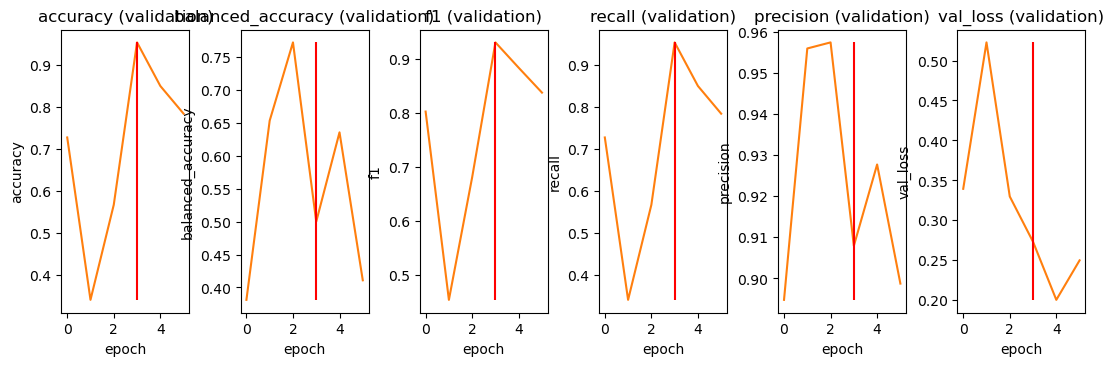

In [41]:
# visualize
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# mark best performing epoch
best_model_epoch = np.argmax(history_val['f1'])

metrics = history_val.keys()
for i, metric in enumerate(metrics):
    plt.subplot(1, 6, i + 1)
    plt.plot(history_val[metric], color='C1')
    plt.vlines(x=best_model_epoch, ymin=min(history_val[metric]), ymax=max(history_val[metric]), color='red')
    plt.title(f'{metric} (validation)')
    plt.ylabel(metric)
    plt.xlabel('epoch')

plt.show()

PCA, t-SNE embeddings

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [42]:
# load fatigue labels
y_true = np.empty(N, dtype=int)
for i in range(N):
    y_true[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[0]

Physical fatigue
Expained variance - 2 components - (cummulative): 0.5802491727417157
Expained variance - 50 components - (cummulative): 0.8815208280424442


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


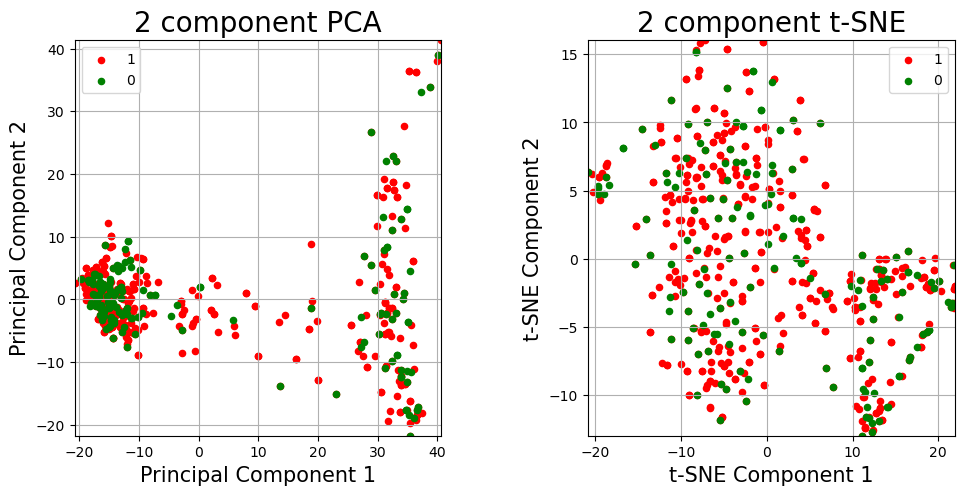

Mental fatigue
Expained variance - 2 components - (cummulative): 0.5802491727417158
Expained variance - 50 components - (cummulative): 0.8815188549290871


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


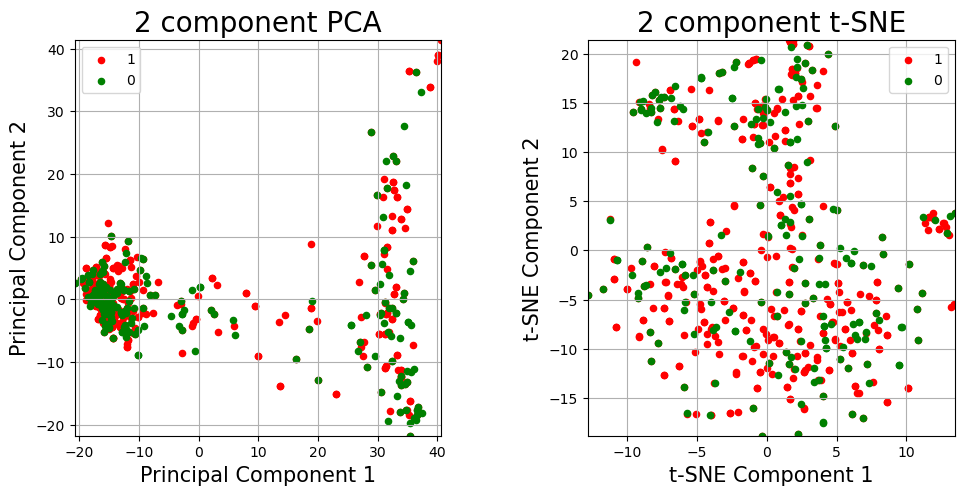

In [67]:
for variable in (0, 1):
    print(('Physical fatigue', 'Mental fatigue')[variable])

    model = CNN(path, variable=variable, epochs=1, learning_rate=1e-3, batch_size=16)

    # load fatigue labels
    y_true = np.empty(N, dtype=int)
    for i in range(N):
        y_true[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[variable]

    # get embeddings from CNN
    embeddings = np.empty((N, 12800), dtype=float)
    for i, (x,y) in enumerate(DataGenerator(path, np.arange(N), batch_size=1, variable=variable)):
        z = [model.model.mobilenet(x[..., i:i+3], training=False) for i in range(0, CHANNELS, 3)]

        # Concatenation
        z = model.model.concat(z)

        # Global pooling
        z = model.model.pool(z)

        embeddings[i, ] = z

    # PCA
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    print(f'Expained variance - 2 components - (cummulative): {np.sum(pca.explained_variance_ratio_)}')

    # visualize
    principalDf = pd.DataFrame(data=pca_embeddings, columns=['principal component 1', 'principal component 2'])

    # concat labels
    labels = pd.DataFrame(data=y_true, columns=['target'])
    finalDf = pd.concat([principalDf, labels[['target']]], axis = 1)

    # plot
    fig = plt.figure(figsize = (8,4))
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.0,
                        wspace=0.4,
                        hspace=0.4)
    ax = fig.add_subplot(1,2,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1, 0]
    colors = ['r', 'g']
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                   finalDf.loc[indicesToKeep, 'principal component 2'],
                   c=color,
                   s=20)

    x_min, x_max = np.min(principalDf.to_numpy()[:, 0]), np.max(principalDf.to_numpy()[:, 0])
    y_min, y_max = np.min(principalDf.to_numpy()[:, 1]), np.max(principalDf.to_numpy()[:, 1])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.legend(targets)
    ax.grid()

    # t-SNE
    # we first reduce the dimensions of the embeddings with PCA as recommended
    pca_50 = PCA(n_components=50, random_state=42)
    pca_embeddings_50 = pca_50.fit_transform(embeddings)
    print(f'Expained variance - 50 components - (cummulative): {np.sum(pca_50.explained_variance_ratio_)}')

    # now we apply t-SNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
    tsne_embeddings = tsne.fit_transform(pca_embeddings_50)

    # visualize
    tsneDf = pd.DataFrame(data=tsne_embeddings, columns=['t-SNE component 1', 't-SNE component 2'])

    # concat labels
    labels = pd.DataFrame(data=y_true, columns=['target'])
    finalDf_tsne = pd.concat([tsneDf, labels[['target']]], axis = 1)

    # plot
    ax = fig.add_subplot(1,2,2)
    ax.set_xlabel('t-SNE Component 1', fontsize = 15)
    ax.set_ylabel('t-SNE Component 2', fontsize = 15)
    ax.set_title('2 component t-SNE', fontsize = 20)
    targets = [1, 0]
    colors = ['r', 'g']
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf_tsne['target'] == target
        ax.scatter(finalDf_tsne.loc[indicesToKeep, 't-SNE component 1'],
                   finalDf_tsne.loc[indicesToKeep, 't-SNE component 2'],
                   c=color,
                   s=20)

    x_min, x_max = np.min(tsneDf.to_numpy()[:, 0]), np.max(tsneDf.to_numpy()[:, 0])
    y_min, y_max = np.min(tsneDf.to_numpy()[:, 1]), np.max(tsneDf.to_numpy()[:, 1])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.legend(targets)
    ax.grid()

    plt.show()

Daily majority vote

In [ ]:
model = CNN(path, variable=0, epochs=10, learning_rate=1e-3, batch_size=16)

N = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')])

# load labels (we need them for stratification)
y = np.empty(N, dtype=int)
for i in range(N):
    y[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[variable]  # TODO: multiclass

# CV
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
scores_cv = []
data_indices = np.arange(N)

print(f'Starting stratified group {5}-fold for {["physical fatigue", "mental fatigue"][variable]}')
with tqdm(total=5) as pbar:
    for i, (train_indices, test_indices) in enumerate(cv.split(X=data_indices, y=y, groups=subjects)):
        # test labels
        y_test = y[test_indices]

        # training
        model.reset()
        model.fit(train_indices)

        # predict
        y_pred = model.predict(test_indices)

        # daily majorities
        y_pred_daily = np.array(list(daily_majority_vote(y_pred, test_indices, metadata).values()))
        y_true_daily = np.array(list(daily_majority_vote(y_test, test_indices, metadata).values()))

        # evaluate
        scores = evaluator(y_pred_daily, y_true_daily, verbose=False)
        scores_cv.append(scores)

        # agreements
        print('agreements:', agreements(y_pred, model.test_indices, metadata))

        # for progress bar
        pbar.update(1)
        pbar.set_description(f' Fold {i+1} F1: {scores["f1"]}')

# print (if verbose==True)
print('Performance model:')
metrics = scores_cv[0].keys()
for metric in metrics:
    mean = np.mean([scores_cv_i[metric] for scores_cv_i in scores_cv])
    std = np.std([scores_cv_i[metric] for scores_cv_i in scores_cv])
    print(f' {metric}: {round(mean, 3)} +- {round(std, 3)} \n')

# TODO: check why so few days (even fewer than statistical features)